In [1]:
import os
from skimage import measure                        
from shapely.geometry import Polygon, MultiPolygon 
import cv2 
from PIL import Image # (pip install Pillow)
from utils.dataset_utils import get_cadisv2_dataset,ZEISS_CATEGORIES,ZEISS_TO_CADISV2,ZEISS_TO_CATARACT1K,get_cataract1k_dataset
import json
from utils.vis_utils import COLORS,NEW_COLORS
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

Coco generation code was adapted from: https://www.immersivelimit.com/create-coco-annotations-from-scratch

In [ ]:
!poetry add matplotlip

In [2]:
def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, positive_orientation='low')#(sub_mask, 0.5, positive_orientation='low')
    #contours, _= cv2.findContours(sub_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
   
    
    segmentations = []
    polygons = []
    for contour in contours:
        #print(contour.shape)
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
       
        #poly = poly.simplify(1.0, preserve_topology=True)
        
        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
       
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
   
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area
    }

    return annotation

In [3]:
def create_sub_masks(mask_image):
    width, height = mask_image.size

    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]
            # If the pixel is not black...
            if pixel != (0, 0, 0):
                # Check to see if we've created a sub-mask...
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                   # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))
                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks


In [4]:
cadis_train_dataset, cadis_val_dataset, cadis_test_dataset= get_cadisv2_dataset("data/CaDISv2", domain_incremental=True)
#cadis_train_dataset.class_mappings

In [6]:
is_crowd=0
annotation_id=1
annotations=[]
image_id=1
images=[]
dataset=cadis_train_dataset
for i in range(len(dataset)):
    
    img,mask,path=dataset[i]
    
    mask_pil=Image.fromarray(mask.numpy().astype('uint8')).convert('RGB')
    images.append({
            "path":path,
            "file_name": path.split("/")[-1],
            "height": mask_pil.size[0],
            "width": mask_pil.size[1],
            "id": image_id
        })
    sub_masks = create_sub_masks(mask_pil)
    for color, sub_mask in sub_masks.items():
        category_id = int(color[1:].split(",")[0])
        if category_id==255:
            continue
        annotation = create_sub_mask_annotation(np.array(sub_mask), image_id, category_id, annotation_id, is_crowd)
        if len(annotation)==0:
            print(image_id,path,"empty annotation",category_id)
        annotations.append(annotation)
        annotation_id += 1
    image_id+=1

In [7]:
categories=[]
for k,v in ZEISS_CATEGORIES.items():
    categories.append({"id":k,"name":v})

final_json={"info":None,"licenses":None,"images":images,"annotations":annotations,"categories": categories}

with open("CaDISv2-train.json", "w") as json_file:
    json.dump(final_json, json_file)


In [8]:
is_crowd=0
annotation_id=1
annotations=[]
image_id=1
images=[]
dataset=cadis_val_dataset
for i in range(len(dataset)):
    
    img,mask,path=dataset[i]
    
    mask_pil=Image.fromarray(mask.numpy().astype('uint8')).convert('RGB')
    images.append({
            "path":path,
            "file_name": path.split("/")[-1],
            "height": mask_pil.size[0],
            "width": mask_pil.size[1],
            "id": image_id
        })
    sub_masks = create_sub_masks(mask_pil)
    for color, sub_mask in sub_masks.items():
        category_id = int(color[1:].split(",")[0])
        if category_id==255:
            continue
        annotation = create_sub_mask_annotation(np.array(sub_mask), image_id, category_id, annotation_id, is_crowd)
        if len(annotation)==0:
            print(image_id,path,"empty annotation",category_id)
        annotations.append(annotation)
        annotation_id += 1
    image_id+=1

In [9]:
categories=[]
for k,v in ZEISS_CATEGORIES.items():
    categories.append({"id":k,"name":v})

final_json={"info":None,"licenses":None,"images":images,"annotations":annotations,"categories": categories}

with open("CaDISv2-val.json", "w") as json_file:
    json.dump(final_json, json_file)


In [24]:
f=open("data/cataract-101/coco-annotations.json")
pre_json=json.load(f)
print(pre_json.keys())
categories=[]
for k,v in ZEISS_CATEGORIES.items():
    categories.append({"id":k,"name":v})

new_annotations=[]

for ann in pre_json["annotations"]:
    for k,v in ZEISS_TO_CATARACT1K.items():
        
        if ann["category_id"] in v:
            
            ann["category_id"]=k
            new_annotations.append(ann)
            break
        
final_json={"info":pre_json["info"],"images":pre_json["images"],
            "annotations":new_annotations,"categories": categories}

with open("cataract101-zeiss-mapped.json", "w") as json_file:
    json.dump(final_json, json_file)


dict_keys(['info', 'images', 'categories', 'annotations'])


In [27]:
# Initialize COCO instance with annotation file
coco = COCO("CaDISv2-train.json")
#path="data/cataract-101/2019-10-16_10-13-16_V.mp4_00397.jpg"
img, mask,path=cadis_train_dataset[15]
image = cv2.imread(path)
# Load annotations for the image
ann_ids = coco.getAnnIds(imgIds=16)

annotations = coco.loadAnns(ann_ids)

# Draw annotations on the image
for ann in annotations:
    bbox = ann['bbox']
    category_id = ann['category_id']
    print(category_id)
    category_info = coco.loadCats(category_id)[0]
    category_name = category_info['name']
    x, y, w, h = [int(coord) for coord in bbox]
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, category_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with annotations
cv2.imshow('Image with Annotations', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

loading annotations into memory...
Done (t=10.68s)
creating index...
index created!
11
10
6


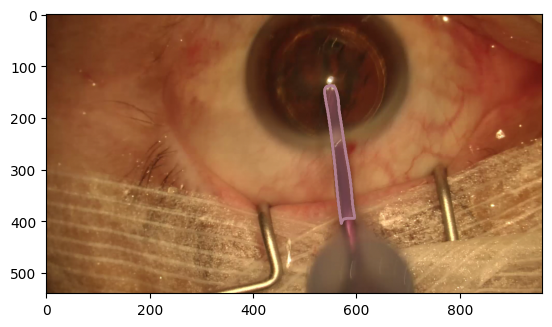

In [28]:

annIds = coco.getAnnIds(imgIds=16, catIds=[6], iscrowd=False)
anns = coco.loadAnns(annIds)
plt.imshow(Image.open(os.getcwd()+"/"+path))#(os.getcwd()+"/"+"data/cataract-101/2019-10-16_10-13-16_V.mp4_00397.jpg"))
coco.showAnns(anns)

In [5]:
for i in range(len(cadis_train_dataset)):
    img,mask,path=cadis_train_dataset[i]
    if "Video3_frame001870" in path:
        print(i)
        break

217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  6  10  11 255]


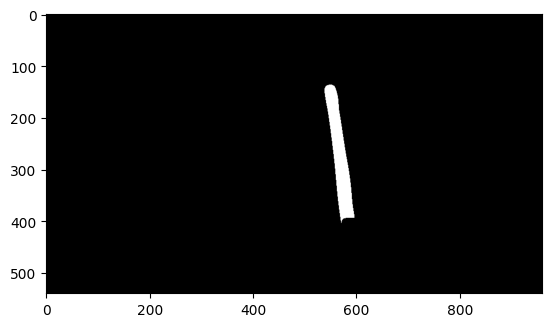

In [26]:
img_path="Video3_frame001870"
img, mask,path=cadis_train_dataset[15]
print(np.unique(mask.numpy()))
class_num=6
class_mask = mask.numpy() == class_num
overlay = np.zeros(img.permute(1, 2, 0).numpy().shape)
overlay[class_mask] = NEW_COLORS[class_num % len(COLORS)]
#overlay /= 255.0
plt.imshow(overlay)